# Размеченные блоки. Аналитика

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/markup_data.csv")

df.head()

,code_block_id,code_block,data_format,graph_vertex_id,errors,marks,kaggle_id,competition_id
0,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,4368
1,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,4368
2,570368,`# load training and testing data \nsubm = pd....,Table,45,No,5,8591010,4368
3,570369,`subm`,Table,41,No,5,8591010,4368
4,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,4368


In [3]:
graph_vertices = pd.read_csv("../data/actual_graph.csv", index_col=0)

graph_vertices.head()

,graph_vertex,graph_vertex_subclass
id,,
1,Hyperparam_Tuning,find_best_score
2,Hyperparam_Tuning,find_best_params
3,Hyperparam_Tuning,find_best_model_class
4,Hyperparam_Tuning,choose model class
5,Hyperparam_Tuning,define_search_space


In [4]:
graph_vertices["full_name"] = graph_vertices["graph_vertex"].str.cat("." + graph_vertices["graph_vertex_subclass"])

In [5]:
# сколько раз продублировали каждый блок?
duplicated_blocks = df[df["code_block_id"].duplicated(keep=False)]

duplicated_blocks["code_block_id"].value_counts()

147241    5
147240    4
570367    3
147243    3
374855    3
163308    3
570396    3
178437    3
177036    2
160004    2
570369    2
374853    2
147239    2
177062    2
178435    2
578208    2
168350    2
179342    2
570397    2
147207    2
570395    2
147225    2
374856    2
147242    2
341814    2
341813    2
179353    2
374838    2
178412    2
147435    2
374890    2
147433    2
147432    2
176999    2
159999    2
147167    2
374871    2
374870    2
374865    2
176970    2
341704    2
147204    2
374852    2
147129    2
570368    2
Name: code_block_id, dtype: int64

In [6]:
# есть ли блоки с ошибками?
(duplicated_blocks["errors"] == "Yes").any()

False

In [7]:
# есть ли несогласованность в разметке одного и того же блока?
(duplicated_blocks.groupby("code_block_id")["graph_vertex_id"].nunique() != 1).any()

False

In [8]:
# ура, со спокойной душой удаляем дубликаты!
df = df.drop_duplicates()

In [9]:
df.head()

,code_block_id,code_block,data_format,graph_vertex_id,errors,marks,kaggle_id,competition_id
0,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,4368
2,570368,`# load training and testing data \nsubm = pd....,Table,45,No,5,8591010,4368
3,570369,`subm`,Table,41,No,5,8591010,4368
7,570370,`# see testing data\ntest_data`,Table,41,No,5,8591010,4368
8,570371,`# ...and training data\ntrain_data`,Table,41,No,5,8591010,4368


In [10]:
sns.set(font_scale=1.2)

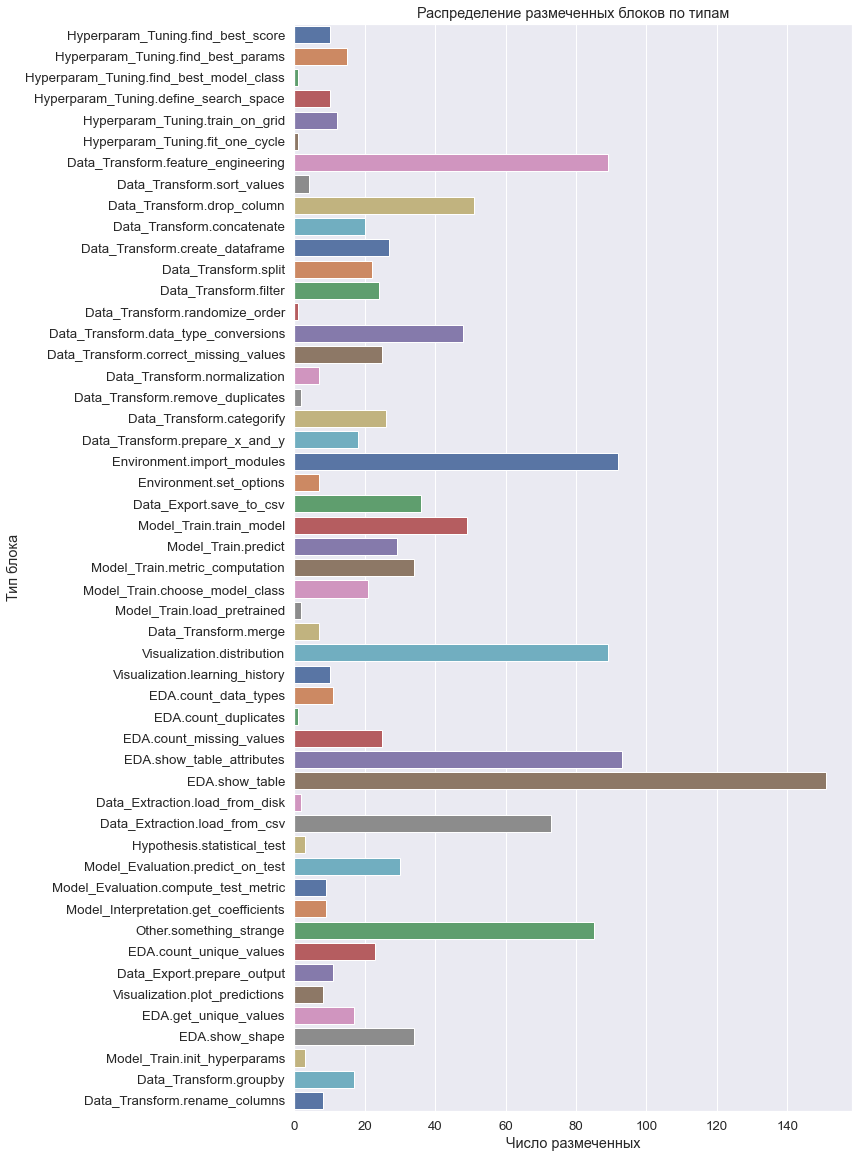

In [11]:
plt.figure(figsize=(10, 20))

ax = sns.countplot(y=df["graph_vertex_id"], palette="deep")
ax.set(
    title="Распределение размеченных блоков по типам",
    ylabel="Тип блока",
    xlabel="Число размеченных",
)

block_ids = [int(label.get_text()) for label in ax.get_yticklabels()]
block_names = graph_vertices.loc[block_ids, "full_name"].values
ax.set_yticklabels(block_names)

plt.grid(True, axis="x")

plt.show()

In [12]:
# теперь еще посмотрим на вершины, которые не были представлены
marked_vertices = df["graph_vertex_id"].unique()
mask = np.full(graph_vertices.shape[0], False)
mask[marked_vertices - 1] = True

graph_vertices.loc[~mask, "full_name"]

id
4     Hyperparam_Tuning.choose model class
24                 Environment.get_options
31                  Data_Transform.augment
34            Visualization.missing_values
36                     Visualization.wandb
42           Data_Extraction.load_from_url
43           Data_Extraction.load_from_sql
46           Hypothesis.pipeline_type_spec
50                 Production.save_weights
51     Production.send_to_prod_environment
Name: full_name, dtype: object

In [13]:
# оценим чистоту блоков
mean_cleanness = df.groupby("graph_vertex_id").agg({"marks": "mean"}).reset_index()

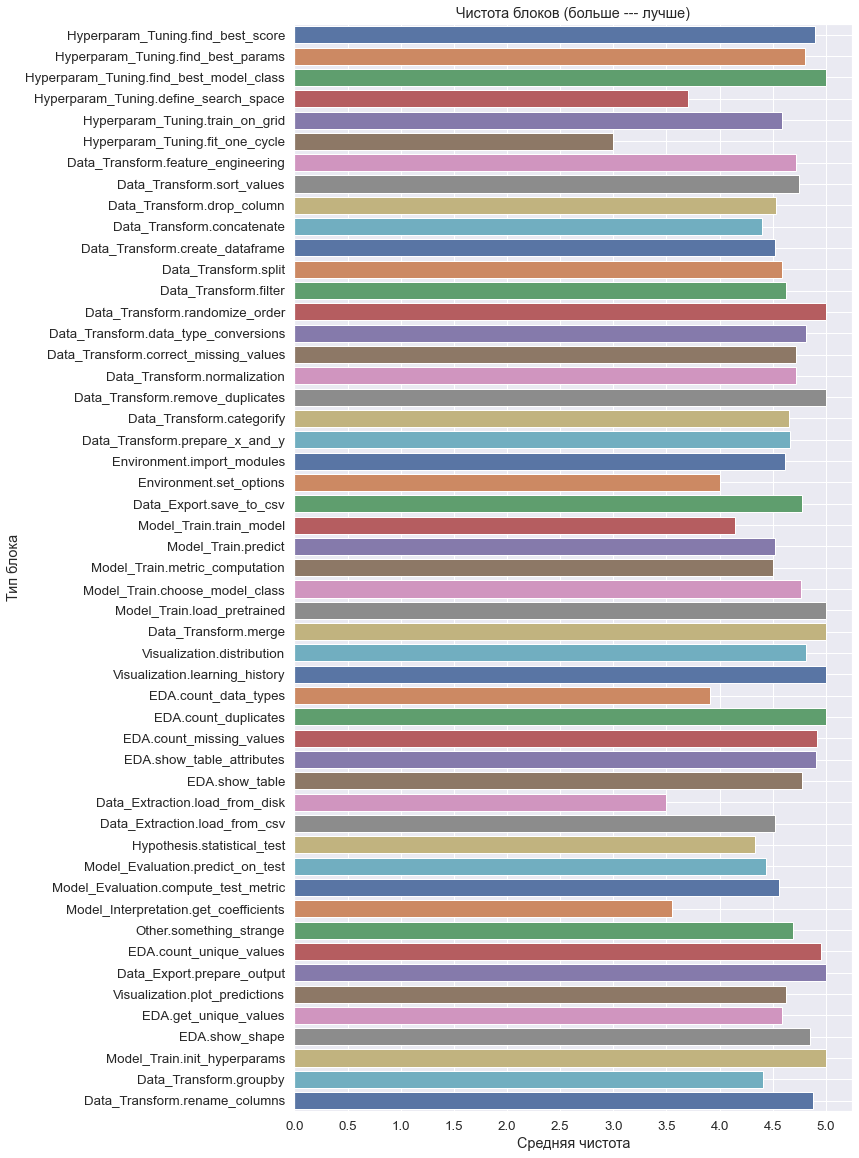

In [14]:
plt.figure(figsize=(10, 20))

ax = sns.barplot(data=mean_cleanness, x="marks", y="graph_vertex_id", orient="h", palette="deep")
ax.set(
    title="Чистота блоков (больше --- лучше)",
    ylabel="Тип блока",
    xlabel="Средняя чистота",
)
ax.set_yticklabels(block_names)
ax.set_xticks(np.linspace(0, 5, 11))

plt.grid(True, axis="y")

plt.show()